Here we want to find the ambient barcodes in the inDrop data. This is slightly different to the dropseq data since here we have a proper ground truth as to which barcodes are definitely errors as the cell barcode is split into two halves (8-12bp and 8bp, respectively) which must match two whitelists. We can therefore match against these whitelists to confidently identify the error barcodes. Those non-error barcodes which fall below well below the knee are likely to be the ambient barcodes. Hopefully these will fall into the same place on the counts vs. dup. rate plot

In [1]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import pysam
import regex
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools
import imp
import itertools
%load_ext rpy2.ipython
%matplotlib inline  

In [2]:
fastq_infile = "../run/raw/indrop_es_1.fastq.1.gz"
fastq_infile2 = "../run/raw/indrop_es_1.fastq.2.gz"

In [3]:
imp.reload(umi_methods)


<module 'umi_tools.umi_methods' from '/home/FILESERVER5/proteomics/tss38/UMI-tools/umi_tools/umi_methods.py'>

In [4]:
# extract UMI, cell and sequence qualities from fastqs

cell_umi_counts = collections.defaultdict(set)
cell_counts = collections.Counter()

qualities = collections.defaultdict(
    lambda: collections.defaultdict(collections.Counter))

p = regex.compile("(?P<cell_1>.{8,12})(?P<discard_2>GAGTGATTGCTTGTGACGCCTT{e<=2})(?P<cell_3>.{8})(?P<umi_1>.{6})T{3}.*")

ReadExtractor = umi_methods.ExtractFilterAndUpdate(
    method="regex", pattern=p, extract_cell=True)

read1s = umi_methods.fastqIterate(U.openFile(fastq_infile))
read2s = umi_methods.fastqIterate(U.openFile(fastq_infile2))

def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

n = 0
n_counter = 0
log_step = 5000000 # log every 5M reads
subset_reads = 50000000 # process first 50M reads

for read1 in read1s:
    
    read2 = next(read2s)
    
    n += 1
    
    values = ReadExtractor.getBarcodes(read1, None)
    
    if values is None:
        continue
    else:
        cell, umi, umi_quals, new_seq, new_quals, new_seq2, new_quals2 = values
    
    cell_umi_counts[cell].add(umi)
    cell_counts[cell] += 1
    
    cell_quals = read1.quals[:12] # extractor doesn't extract the cell quals. grrrr...
    qualities[cell]['read'].update(phredToInt(read2.quals))
    qualities[cell]['umi'].update(phredToInt(umi_quals))
    
    while n > n_counter:
        n_counter += log_step
        print("processed %dM reads" % (float(n)/1000000))
        
    if n > subset_reads:
        break

print("processed %dM reads" % (float(n)/1000000))

final_qualities = collections.defaultdict(lambda: collections.defaultdict(float))


   
print(final_qualities['AGCTATAGTGGG'])



processed 0M reads
processed 5M reads
processed 10M reads
processed 15M reads
processed 20M reads
processed 25M reads
processed 30M reads
processed 35M reads
processed 40M reads
processed 45M reads
processed 50M reads
processed 50M reads
defaultdict(<class 'float'>, {})


In [88]:
def getCounterMean(counter):
    sum_of_numbers = sum([number*count for number, count in counter.most_common()])
    count = sum(count for n, count in counter.most_common())
    mean = sum_of_numbers / count
    return mean 


for cell in qualities:
    final_qualities[cell]['read'] = getCounterMean(qualities[cell]['read'])
    final_qualities[cell]['umi'] = getCounterMean(qualities[cell]['umi'])   

In [5]:
whitelist_left_inf = "../run/indrop_barcode_list_1.txt"
whitelist_right_inf = "../run/indrop_barcode_list_2.txt"

def reverseComp(seq):
    comp = {"A": "T",
            "T": "A",
            "C": "G",
            "G": "C",
            "N": "N"}

    return "".join([comp[x] for x in seq[::-1]])

def getWhitelistFromFile(infile):
    
    whitelist = set()
    
    with IOTools.openFile(infile, "r") as inf:
        for line in inf:
            whitelist.add(reverseComp(line.strip().split("\t")[0]))
    
    return whitelist

whitelist_left = getWhitelistFromFile(whitelist_left_inf)
whitelist_right = getWhitelistFromFile(whitelist_right_inf)

combined_whitelist = set()
for left in whitelist_left:
    for right in whitelist_right:
        combined_whitelist.add(left+right)

print(len(whitelist_left))
print(len(whitelist_right))
print(len(combined_whitelist))

384
384
147456


In [6]:
rows = []
n = 0
for cell in cell_umi_counts:
    cell_left = cell[:-8]
    cell_right = cell[-8:]
    
    if (cell_left in whitelist_left and cell_right in whitelist_right):
        error = "In cell whitelists"
    else:
        error = "Not in cell whitelists"

    if cell == "TGAGGTTTCTCACGACGGT":
        print(cell, error)

    row = (cell,
           cell_counts[cell],
           error,
           len(cell_umi_counts[cell]),
           1-(len(cell_umi_counts[cell])/cell_counts[cell]))
    
    rows.append(row)
    #if cell_counts[cell] != len(cell_umi_counts[cell]):
    if error == "True Barcode":
        n += 1
        if n < 10:
            print(row)
#print(cell_umi_counts)

TGAGGTTTCTCACGACGGT Not in cell whitelists


In [71]:
duplication_df = pd.DataFrame.from_records(
    rows, columns=["cell", "count", "error", "unique_umi_count", "dup._rate"])
print(sum(duplication_df['count']))
print(duplication_df.head())
print(duplication_df.shape)
duplication_df = duplication_df[duplication_df['count']>100]
print(duplication_df.head())
print(duplication_df.shape)

29883225
                 cell  count                   error  unique_umi_count  \
0    AAGAATCAATAACAAG      1  Not in cell whitelists                 1   
1   AATGGAGAATCCTTTAA      1  Not in cell whitelists                 1   
2   AGCCTCATTTCTCATTC      1  Not in cell whitelists                 1   
3  GAACGTATTAAAGACCGA      1  Not in cell whitelists                 1   
4  GAAAAGAAACGTCCAAAT      1  Not in cell whitelists                 1   

   dup._rate  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
(1521247, 5)
                    cell  count                   error  unique_umi_count  \
116   GAGGACTTCCGTTGTCAT    666      In cell whitelists               445   
387    AATACTCTAACGTTGCT    124  Not in cell whitelists               122   
397     CGTATTTCTGCCATCG    494      In cell whitelists               333   
431  TGATAACCCGTGGGAAATC    327      In cell whitelists               159   
607  TGAACGCTCAGTAGCGTAC    206  Not in cell whitelists   

In [98]:
whitelist_inf = "../run/extract/indrop_es_1_whitelist_method_umis.tsv"
indrop_knee = set()
with IOTools.openFile(whitelist_inf, "r") as inf:
    for line in inf:
        indrop_knee.add(line.split("\t")[0])
        
print(len(indrop_knee))

whitelisted_knee = indrop_knee.intersection(
    duplication_df[duplication_df['error']=='In cell whitelists']['cell'])

print(len(whitelisted_knee))

0
0


In [72]:
duplication_df["knee"] = [x in indrop_knee for x in duplication_df['cell']]

In [10]:
def checkError(barcode, whitelist):
    near_matches = set()
    comp_regex = regex.compile("(%s){e<=1}" % barcode)
    b_length = len(barcode)
    for whitelisted_barcode in whitelist:
        w_length = len(whitelisted_barcode)
        if barcode == whitelisted_barcode:
            continue
        if (max(b_length, w_length) > (min(b_length, w_length) + 1)):
            continue
        if comp_regex.match(whitelisted_barcode):
            near_matches.add(whitelisted_barcode)
            if len(near_matches) > 1:
                return near_matches

    return near_matches


In [11]:
print(checkError("TGAGGTTTCTCTCGACGGT", combined_whitelist))
print(checkError("TGAGGTTTCTCTCGACGG", combined_whitelist))
print(checkError("TGAGGTTTCTCTCGACGGA", combined_whitelist))
print(checkError("TGAGGTTCTCTCGACGGT", combined_whitelist))

set()
{'TGAGGTTTCTCTGACGGAC', 'TGAGGTTTCTCTCGACGGT'}
{'TGAGGTTTCTCTGACGGAC', 'TGAGGTTTCTCTCGACGGT'}
{'TGAGGTTTCTCTCGACGGT'}


In [12]:
#error = []
#error_barcode = []

print(len(duplication_df['cell']))
n = 0
for barcode in duplication_df['cell']:
    n+=1
    if n % 1000 == 0:
        print("processed %i cell barcodes" % n)
    barcode_errors = checkError(barcode, combined_whitelist)
    
    if len(barcode_errors) > 0:
        error.append("Error off whitelist")
        if len(barcode_errors) <= 2:
            error_barcode.append(list(barcode_errors)[0])
        else:
            error_barcode.append("")
    
    else:
        error.append("")
        error_barcode.append("")               
    
duplication_df['full_error'] = error
duplication_df['error_barcode'] = error_barcode

13059
processed 1000 cell barcodes
processed 2000 cell barcodes
processed 3000 cell barcodes
processed 4000 cell barcodes
processed 5000 cell barcodes
processed 6000 cell barcodes
processed 7000 cell barcodes
processed 8000 cell barcodes
processed 9000 cell barcodes
processed 10000 cell barcodes
processed 11000 cell barcodes
processed 12000 cell barcodes
processed 13000 cell barcodes


In [73]:
duplication_df['full_error'] = error
duplication_df['error_barcode'] = error_barcode

In [74]:
print(len(whitelisted_knee))
print(collections.Counter(duplication_df['full_error']))

883
Counter({'': 7830, 'Error off whitelist': 5229})


In [75]:
barcode = "TGAGGTTTCTCTCGACGGT"
cell_l = barcode[:-8]
cell_r = barcode[-8:]
print(cell_l, cell_r)
print(cell_l in whitelist_left, cell_r in whitelist_right)
print(reverseComp(cell_l), reverseComp(cell_r))

TGAGGTTTCTC TCGACGGT
True True
GAGAAACCTCA ACCGTCGA


In [89]:
duplication_df['read_qual'] = [final_qualities[cell]['read'] for cell in duplication_df['cell']]
duplication_df['umi_qual'] = [final_qualities[cell]['umi'] for cell in duplication_df['cell']]

In [90]:
%%R -i duplication_df
library(ggplot2)
library(Hmisc)

print(head(duplication_df))

my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)


                   cell count                  error unique_umi_count
116  GAGGACTTCCGTTGTCAT   666     In cell whitelists              445
387   AATACTCTAACGTTGCT   124 Not in cell whitelists              122
397    CGTATTTCTGCCATCG   494     In cell whitelists              333
431 TGATAACCCGTGGGAAATC   327     In cell whitelists              159
607 TGAACGCTCAGTAGCGTAC   206 Not in cell whitelists               72
761  GATTTAACAGGATCGCAG  2870 Not in cell whitelists              842
     dup._rate  knee          full_error       error_barcode read_qual umi_qual
116 0.33183183 FALSE                                          29.91019 34.76502
387 0.01612903 FALSE                                          28.93565 32.69892
397 0.32591093 FALSE                                          30.53524 35.26350
431 0.51376147 FALSE                                          31.38301 35.05250
607 0.65048544 FALSE Error off whitelist TGAACGCTCAGAAGCGTAC  32.63887 35.49110
761 0.70662021 FALSE Error off

In [91]:
%%R
print(duplication_df[duplication_df['cell']=='TGAGGTTTCTCACGACGGT',])
tmp_df <- duplication_df[duplication_df["knee"]==T,]
tmp_df <- tmp_df[tmp_df$full_error=="Error off whitelist",]
tmp_df <- tmp_df[tmp_df$error=="In cell whitelists",]
print(head(tmp_df))

                      cell count                  error unique_umi_count
645529 TGAGGTTTCTCACGACGGT 19852 Not in cell whitelists             2952
       dup._rate knee          full_error       error_barcode read_qual
645529 0.8512996 TRUE Error off whitelist TGAGGTTTCTCTCGACGGT    33.432
       umi_qual cell_qual
645529  35.7251         0
                      cell count              error unique_umi_count dup._rate
9837   TGAGACAACTTTCGGTACG 19018 In cell whitelists             2999 0.8423073
23917     AACTTAGCTACCAGGC  8909 In cell whitelists             2196 0.7535077
35059    AACTCACCGTTGATTCT 21993 In cell whitelists             3181 0.8553631
57320   GAACTGCCGTTCGGTTCG 14295 In cell whitelists             2693 0.8116125
67392    ATCGGTTCGGTGTAACC  9217 In cell whitelists             2127 0.7692308
119845    CGACGTCACGACTCCT  6935 In cell whitelists             1887 0.7279019
       knee          full_error       error_barcode read_qual umi_qual
9837   TRUE Error off whitelist TG

In [92]:
%%R
not_in_whitelist_df <- duplication_df[duplication_df['error']=="Not in cell whitelists",]
print(dim(not_in_whitelist_df))
not_in_whitelist_df <- not_in_whitelist_df[not_in_whitelist_df$error_barcode!="",]
print(dim(not_in_whitelist_df))

whitelist_cell_count_df <- duplication_df[,c("cell","count")]
colnames(whitelist_cell_count_df) <- c("whitelist_barcode", "whitelist_barcode_count")
print(head(whitelist_cell_count_df))
print("----")
print(head(not_in_whitelist_df))
print("----")
not_in_whitelist_df = merge(not_in_whitelist_df, whitelist_cell_count_df,
                            by.x="error_barcode", by.y="whitelist_barcode", all.x=T)
print(dim(not_in_whitelist_df))
print(head(not_in_whitelist_df))

[1] 6388   11
[1] 4714   11
      whitelist_barcode whitelist_barcode_count
116  GAGGACTTCCGTTGTCAT                     666
387   AATACTCTAACGTTGCT                     124
397    CGTATTTCTGCCATCG                     494
431 TGATAACCCGTGGGAAATC                     327
607 TGAACGCTCAGTAGCGTAC                     206
761  GATTTAACAGGATCGCAG                    2870
[1] "----"
                    cell count                  error unique_umi_count
607  TGAACGCTCAGTAGCGTAC   206 Not in cell whitelists               72
761   GATTTAACAGGATCGCAG  2870 Not in cell whitelists              842
1056   AGCAACCTGAAGCGGTA   134 Not in cell whitelists               52
1165 TGAAACACACGAGTTTCTC   112 Not in cell whitelists               42
1333 TGAGAGTTCACATGGATGG   135 Not in cell whitelists               52
1463  GAACTGCCGTTCGGATCG   132 Not in cell whitelists              128
      dup._rate  knee          full_error       error_barcode read_qual
607  0.65048544 FALSE Error off whitelist TGAACGCTCAGAAG

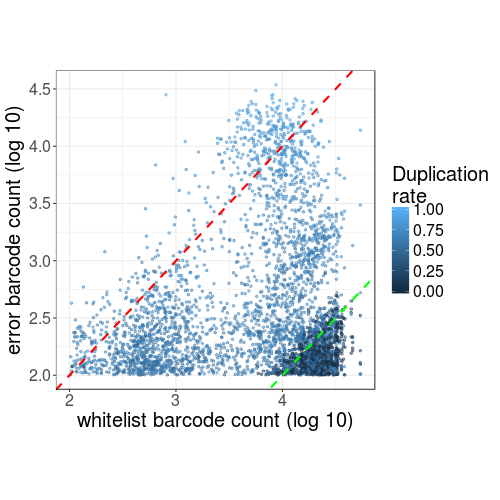

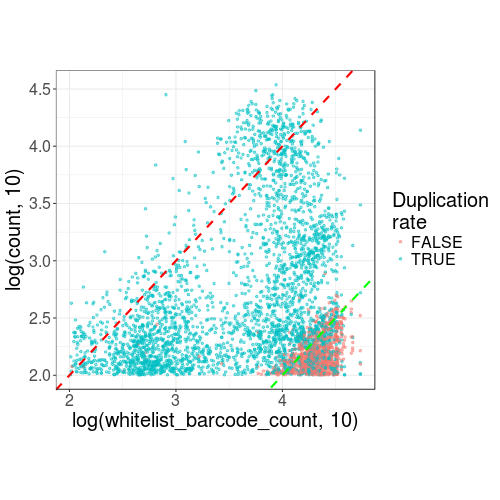

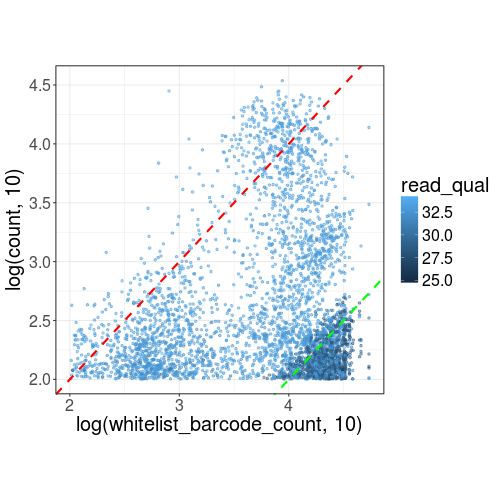

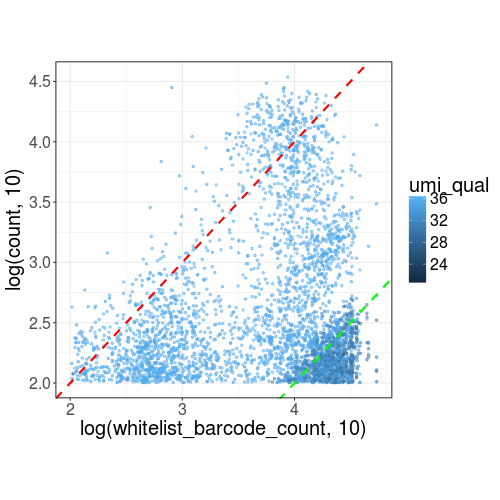

In [96]:
%%R -w 500 -h 500
p <- ggplot(not_in_whitelist_df, aes(log(whitelist_barcode_count,10), log(count,10), colour=dup._rate)) +
geom_point(size=1, alpha=0.5) + my_theme +
geom_abline(slope=1, colour="red", linetype=2, size=1) +
geom_abline(slope=1, intercept=-2, colour="green", linetype=2, size=1) +
scale_colour_continuous(name="Duplication\nrate", limits=c(0,1)) +
xlab("whitelist barcode count (log 10)") +
ylab("error barcode count (log 10)")

print(p)

p <- ggplot(not_in_whitelist_df, aes(log(whitelist_barcode_count,10), log(count,10), colour=dup._rate>0.2)) +
geom_point(size=1, alpha=0.5) + my_theme +
geom_abline(slope=1, colour="red", linetype=2, size=1) +
geom_abline(slope=1, intercept=-2, colour="green", linetype=2, size=1) +
scale_colour_discrete(name="Duplication\nrate")

print(p)


p <- ggplot(not_in_whitelist_df, aes(log(whitelist_barcode_count,10), log(count,10), colour=read_qual)) +
geom_point(size=1, alpha=0.5) + my_theme +
geom_abline(slope=1, colour="red", linetype=2, size=1) +
geom_abline(slope=1, intercept=-2, colour="green", linetype=2, size=1)

print(p)

p <- ggplot(not_in_whitelist_df, aes(log(whitelist_barcode_count,10), log(count,10), colour=umi_qual)) +
geom_point(size=1, alpha=0.5) + my_theme +
geom_abline(slope=1, colour="red", linetype=2, size=1) +
geom_abline(slope=1, intercept=-2, colour="green", linetype=2, size=1)


print(p)

In [104]:
%%R
tmp_df <- duplication_df
tmp_df <- tmp_df[tmp_df$error=="In cell whitelists",]
tmp_df <- tmp_df[tmp_df$full_error=="Error off whitelist",]
tmp_df <- tmp_df[order(-tmp_df$count),]
print(head(tmp_df))

                       cell count              error unique_umi_count dup._rate
587142   GACTAGACCCAAACGCCT 37400 In cell whitelists             3506 0.9062567
939930  TGAAGCGCGATCTTCAGGT 32575 In cell whitelists             3606 0.8893016
808672  TGACACAAGGCAAATGTCG 31967 In cell whitelists             3470 0.8914506
1188307  GACGAATAATAAATGTCG 31092 In cell whitelists             3433 0.8895857
729288   GAGAAAGACCGTTCTGTT 27638 In cell whitelists             3512 0.8729286
1070871 TGATAACCCGTAAGGTAAT 26410 In cell whitelists             3436 0.8698978
        knee          full_error       error_barcode read_qual umi_qual
587142  TRUE Error off whitelist  GACTAGACCCAAAGCCTA  32.77554 35.40068
939930  TRUE Error off whitelist TGAAGCGCGATCTTAGGTA  32.99324 35.49979
808672  TRUE Error off whitelist TGACACAAGGCAAAGTCGG  32.67330 35.00519
1188307 TRUE Error off whitelist  GACGAATAATAAAGTCGG  32.86592 34.68309
729288  TRUE Error off whitelist  GAGAAAGACCGTTTGTTT  32.54348 35.38816
1070871 

[1] 1308
[1] 983


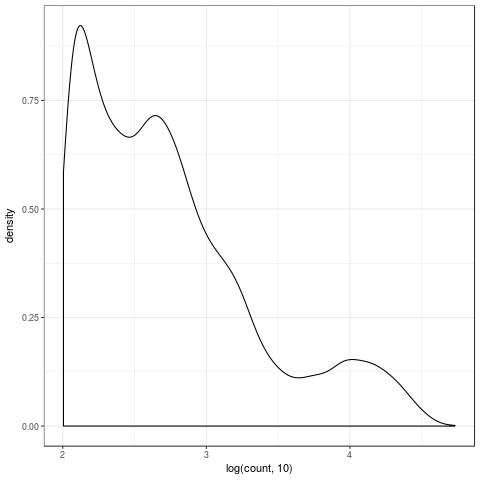

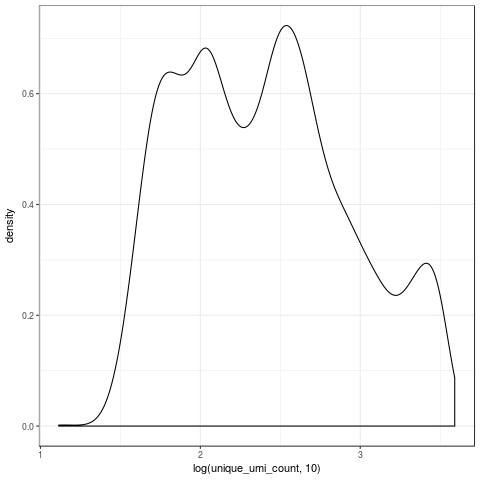

In [118]:
%%R
p <- ggplot(duplication_df, aes(log(count, 10))) + geom_density() + theme_bw()
print(p)

p <- ggplot(duplication_df[duplication_df$unique_umi_count>10,],
            aes(log(unique_umi_count, 10))) +
geom_density() + theme_bw()
print(p)


print(sum(log(duplication_df$count,10)>3.7))
print(sum(log(duplication_df$unique_umi_count,10)>3.3))

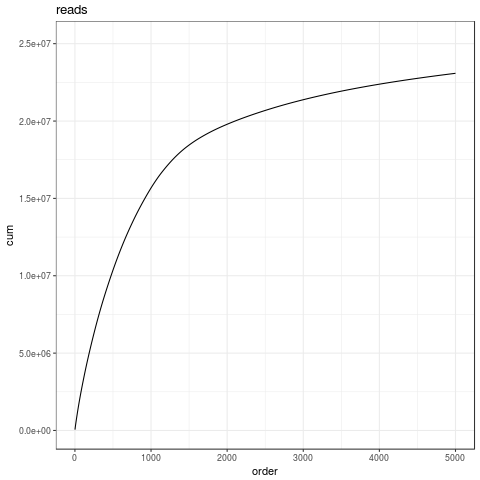

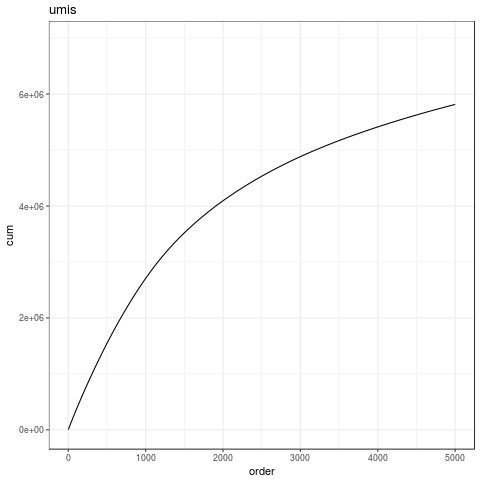

In [124]:
%%R
tmp_df <- duplication_df[order(-duplication_df$count),]
tmp_df$order = seq(1, length(tmp_df[,1]))

tmp_df2 <- duplication_df[order(-duplication_df$unique_umi_count),]
tmp_df2$order = seq(1, length(tmp_df2[,1]))

tmp_df$cum <- cumsum(tmp_df$count)
tmp_df2$cum <- cumsum(tmp_df2$unique_umi_count)


p <- ggplot(tmp_df, aes(order, cum)) + geom_line() + theme_bw() + ggtitle("reads") + xlim(0,5000)
print(p)

p <- ggplot(tmp_df2, aes(order, cum)) + geom_line() + theme_bw() + ggtitle("umis") + xlim(0,5000)
print(p)

In [120]:
%%R
print(head(duplication_df,))

                   cell count                  error unique_umi_count
116  GAGGACTTCCGTTGTCAT   666     In cell whitelists              445
387   AATACTCTAACGTTGCT   124 Not in cell whitelists              122
397    CGTATTTCTGCCATCG   494     In cell whitelists              333
431 TGATAACCCGTGGGAAATC   327     In cell whitelists              159
607 TGAACGCTCAGTAGCGTAC   206 Not in cell whitelists               72
761  GATTTAACAGGATCGCAG  2870 Not in cell whitelists              842
     dup._rate  knee          full_error       error_barcode read_qual umi_qual
116 0.33183183 FALSE                                          29.91019 34.76502
387 0.01612903 FALSE                                          28.93565 32.69892
397 0.32591093 FALSE                                          30.53524 35.26350
431 0.51376147 FALSE                                          31.38301 35.05250
607 0.65048544 FALSE Error off whitelist TGAACGCTCAGAAGCGTAC  32.63887 35.49110
761 0.70662021 FALSE Error off

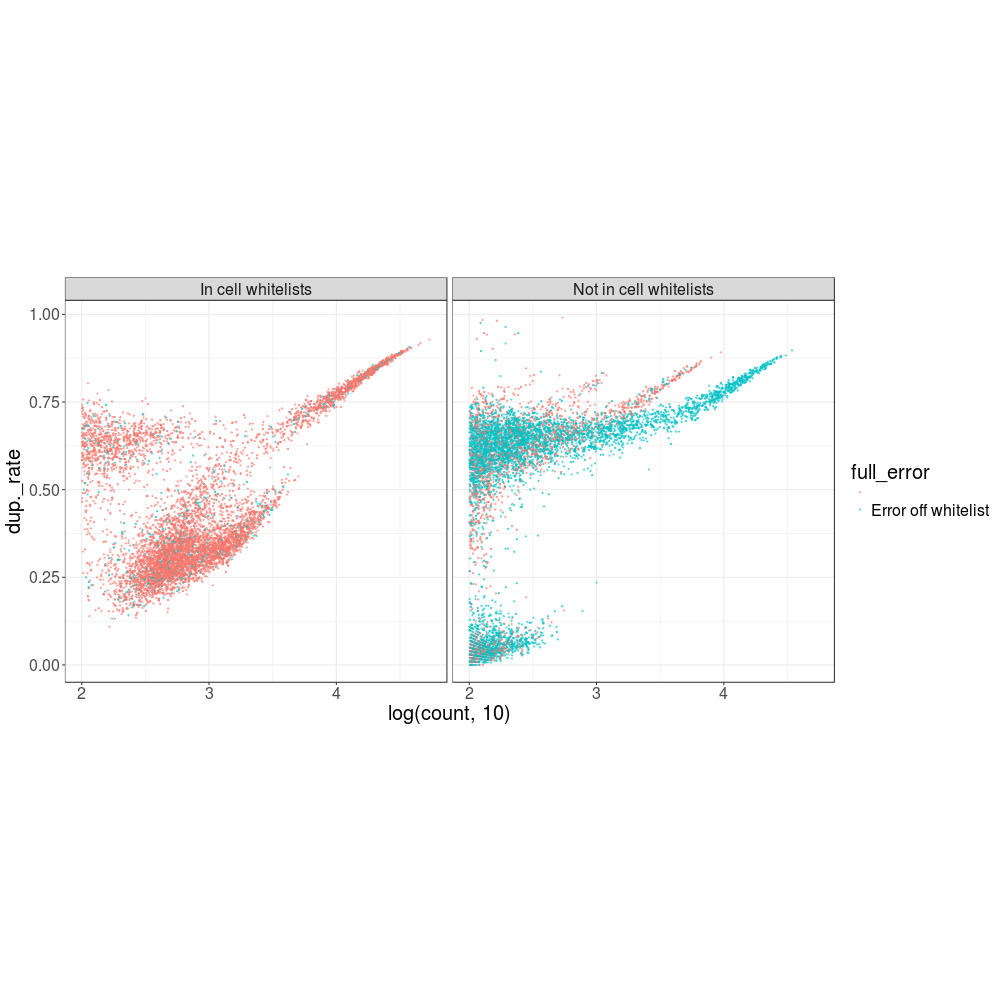

In [128]:
%%R -w 1000 -h 1000
p <- ggplot(duplication_df, aes(log(count, 10), dup._rate, colour=full_error)) +
geom_point(alpha=0.5, size=0.5) + my_theme + facet_wrap(~error)
print(p)

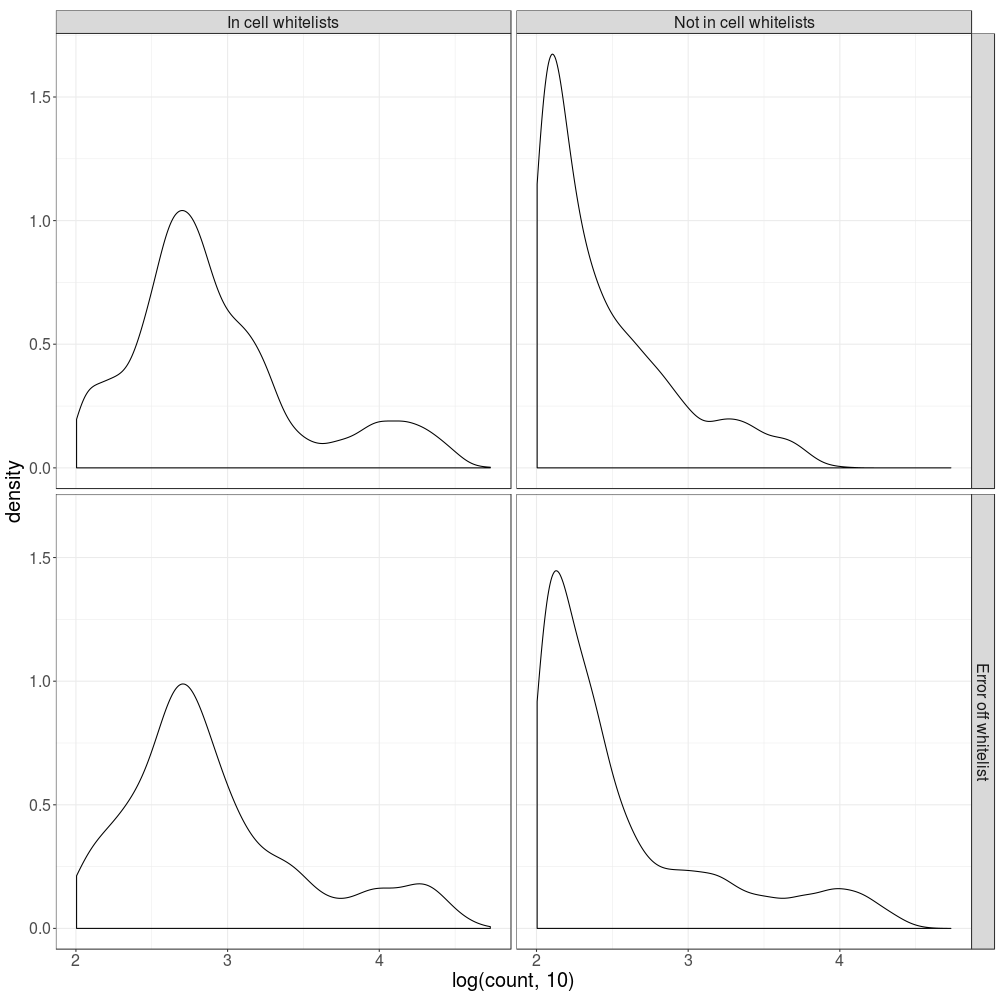

In [19]:
%%R -w 1000 -h 1000
p <- ggplot(duplication_df, aes(log(count, 10))) +
geom_density() + my_theme + facet_grid(full_error~error)
print(p)